In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'DKK=X'
numbers_in_currency = 'DKK'
share_name = 'SOLAR-B.CO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2018-03-31,2817,-2242,575,94,23,1612,1421,3254,0,...,1888,0,239,2694,416,3240,-34,-40,7.3,2018-05-05
1,2018-06-30,2733,-2176,557,1,27,1512,1426,3027,0,...,1742,0,277,2464,412,3004,-41,-34,7.3,2018-08-09
2,2018-09-30,2539,-2026,513,55,13,1610,1441,3121,0,...,1739,0,314,2512,411,3048,-20,-30,7.3,2018-11-04
3,2018-12-31,3356,-2574,782,168,65,1452,1521,3117,0,...,1883,0,117,2452,411,2995,319,-43,7.3,2019-02-09
4,2019-03-31,2957,-2457,500,-18,60,1732,1570,3425,0,...,1971,0,511,2936,405,3649,-137,-31,7.3,2019-05-05


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)

## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
19,2022-12-31,2023-02-09,7.33,3684,-2925,759,169,166,1859,2248,...,5901,1902,0,673,3261,293,3970,232,-39,7.295020
20,2023-03-31,2023-05-05,7.33,3656,-2928,728,145,276,2134,2362,...,6614,2149,0,1222,4118,291,4904,101,-50,6.936642
21,2023-06-30,2023-08-09,7.33,3250,-2611,639,77,262,1922,2276,...,6317,1933,0,1074,3613,439,4556,78,-55,6.841692
22,2023-09-30,2023-11-04,7.33,2965,-2409,556,71,241,1939,2178,...,6265,1864,0,994,3478,437,4404,190,-102,6.848087
23,2023-12-31,2024-02-09,7.33,3160,-2552,608,55,441,1648,2029,...,6112,1770,0,844,3222,434,4180,486,-65,6.933528


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2018-05-07,254.172104,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.329748,0.670252,0.0,0.0,0.0,0.0,0.204118,0.033369,0.0,0.0
1,2018-05-14,253.548401,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.329748,0.670252,0.0,0.0,0.0,0.0,0.204118,0.033369,0.0,0.0
2,2018-05-21,249.182220,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.329748,0.670252,0.0,0.0,0.0,0.0,0.204118,0.033369,0.0,0.0
3,2018-05-28,252.300903,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.329748,0.670252,0.0,0.0,0.0,0.0,0.204118,0.033369,0.0,0.0
4,2018-06-04,251.053452,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.329748,0.670252,0.0,0.0,0.0,0.0,0.204118,0.033369,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2018-05-07,254.172104,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.0,0.204118,0.033369,0.0,0.0,inf,1.164025,0.164666,0.450165,inf
1,2018-05-14,253.548401,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.0,0.204118,0.033369,0.0,0.0,inf,1.161169,0.164262,0.449761,inf
2,2018-05-21,249.182220,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.0,0.204118,0.033369,0.0,0.0,inf,1.141173,0.161433,0.446932,inf
3,2018-05-28,252.300903,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.0,0.204118,0.033369,0.0,0.0,inf,1.155456,0.163454,0.448952,inf
4,2018-06-04,251.053452,2018-03-31,2817.0,0.0,218.356164,7.3,0.0,0.0,23.0,...,0.0,0.204118,0.033369,0.0,0.0,inf,1.149743,0.162646,0.448144,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

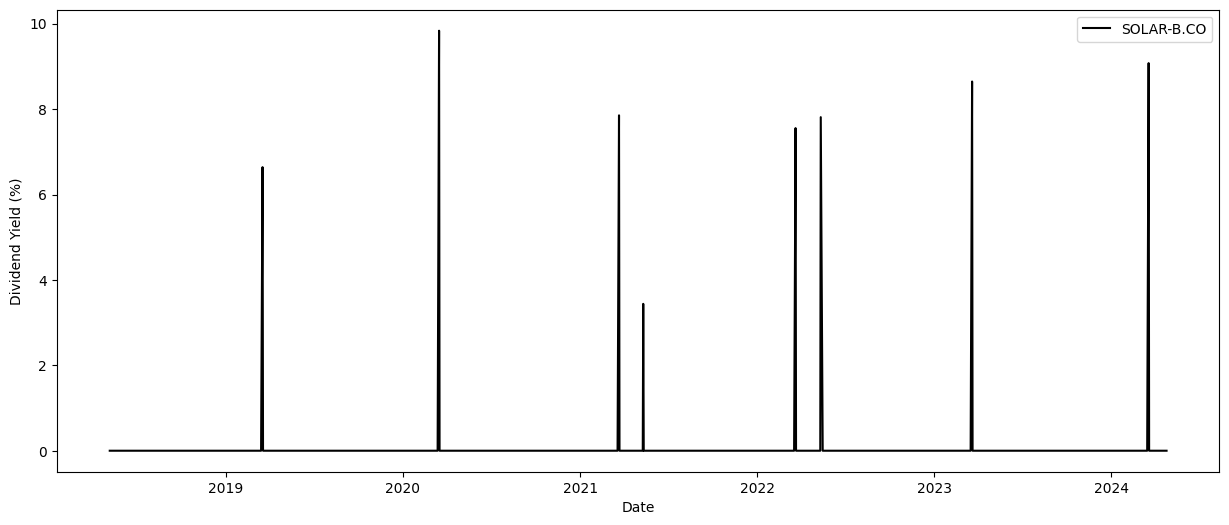

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.352874
share_price      1.000000
Name: share_price, dtype: float64


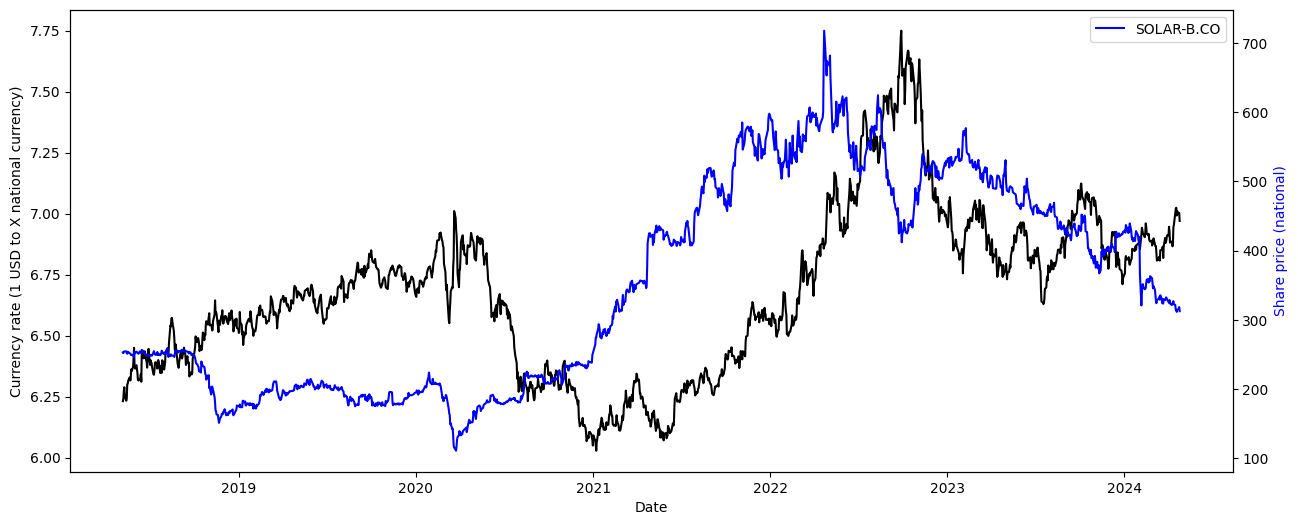

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

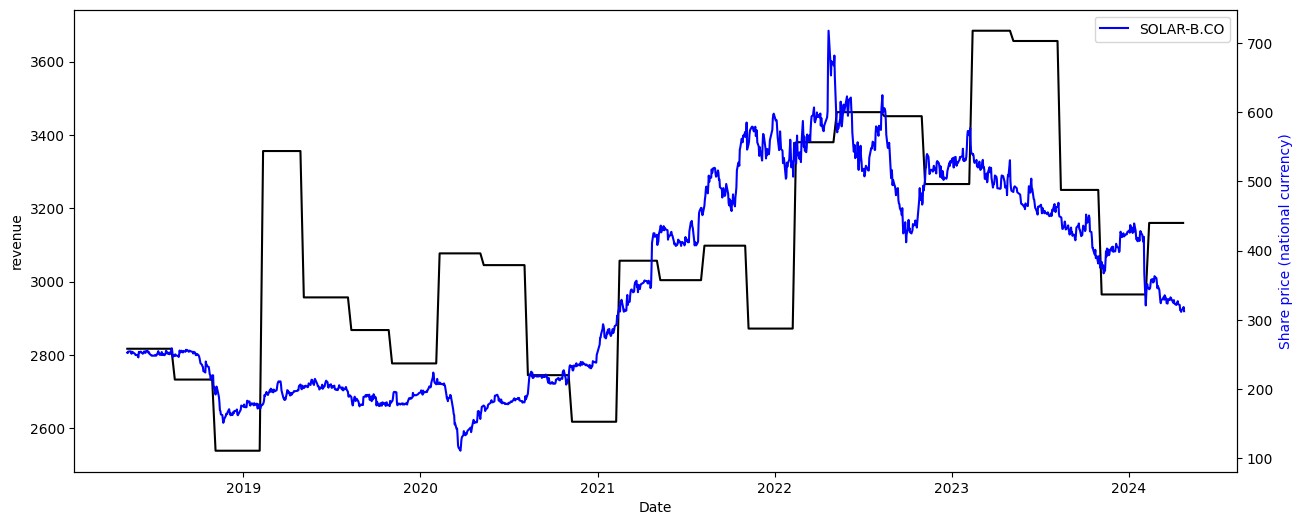

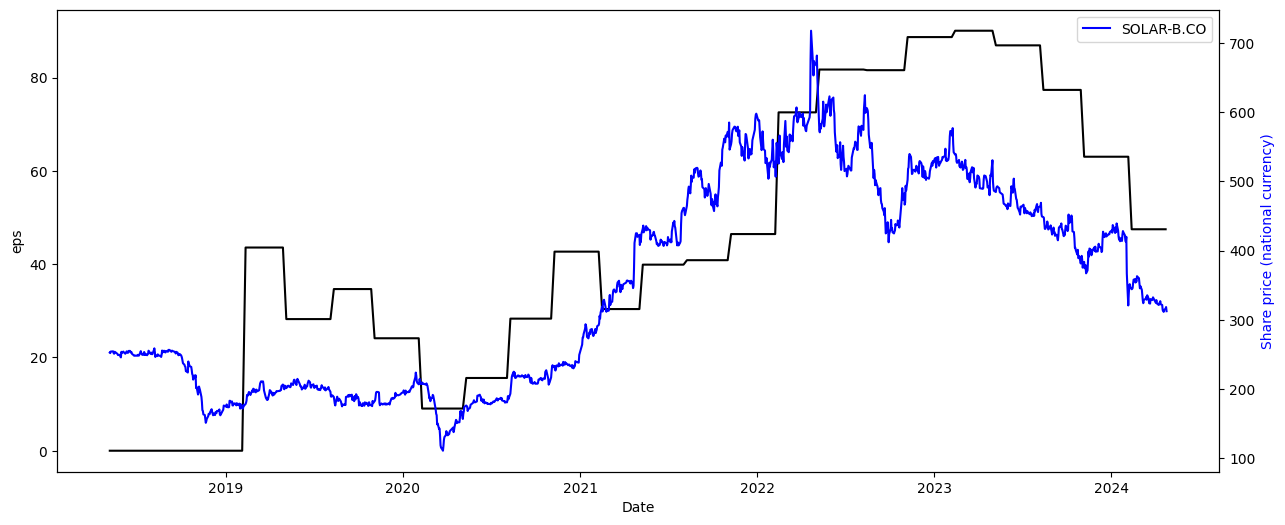

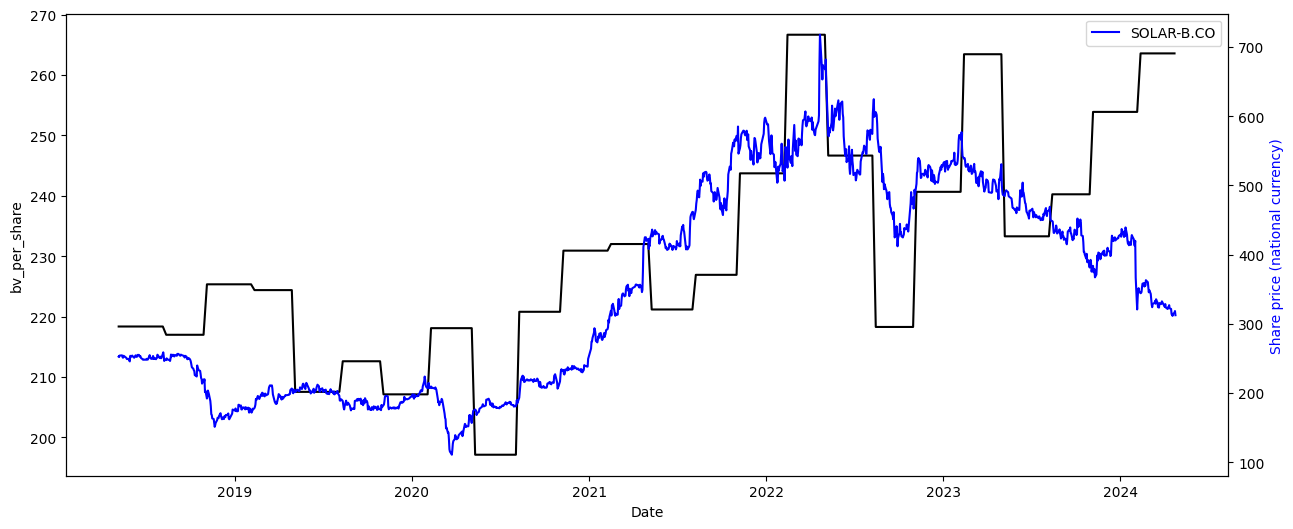

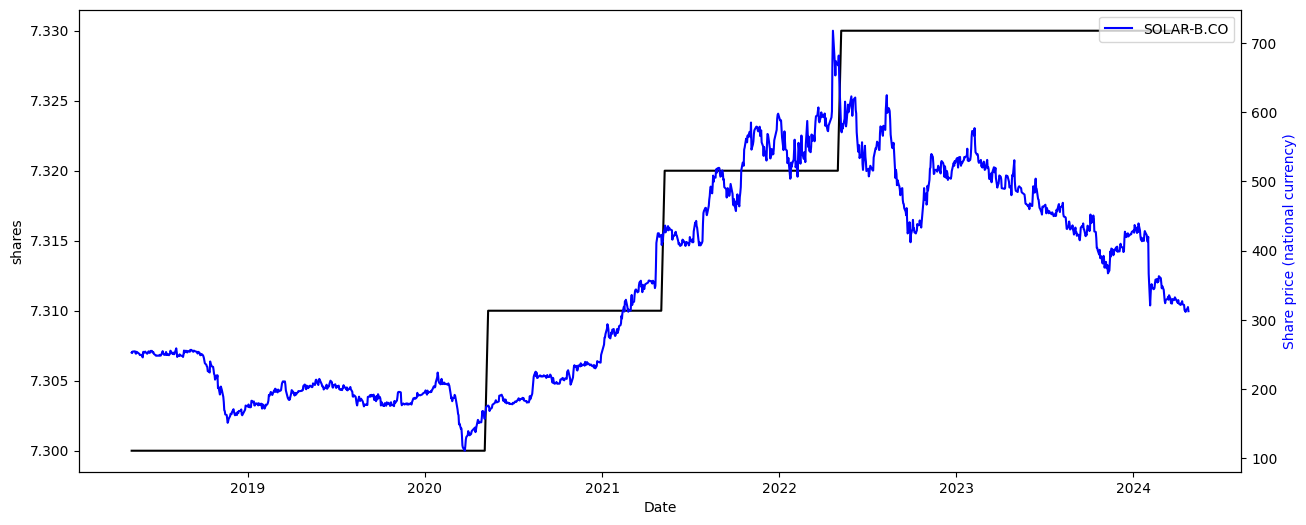

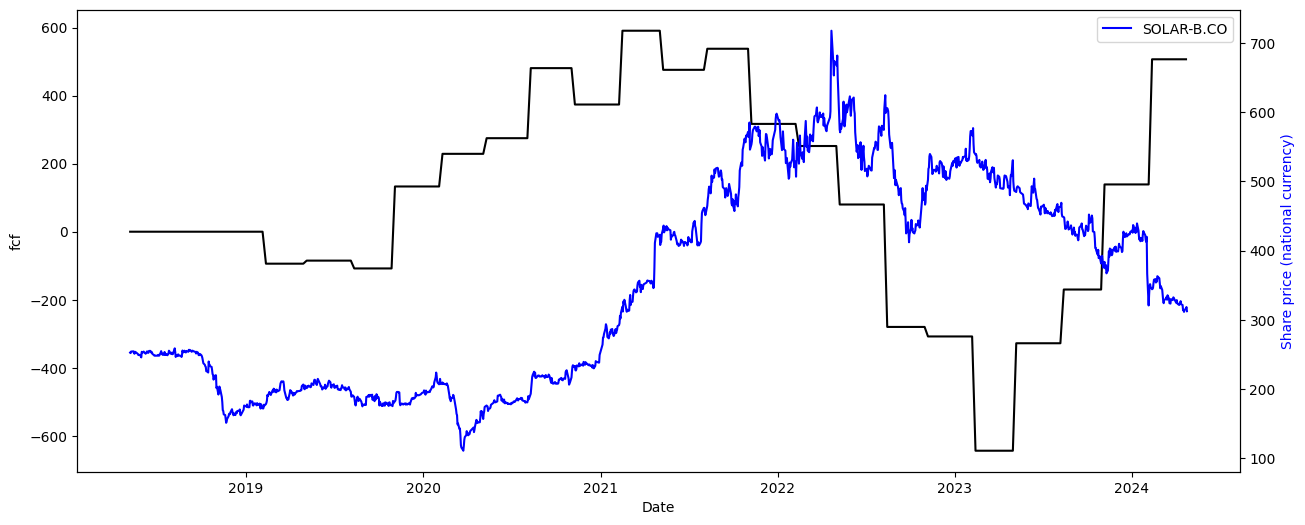

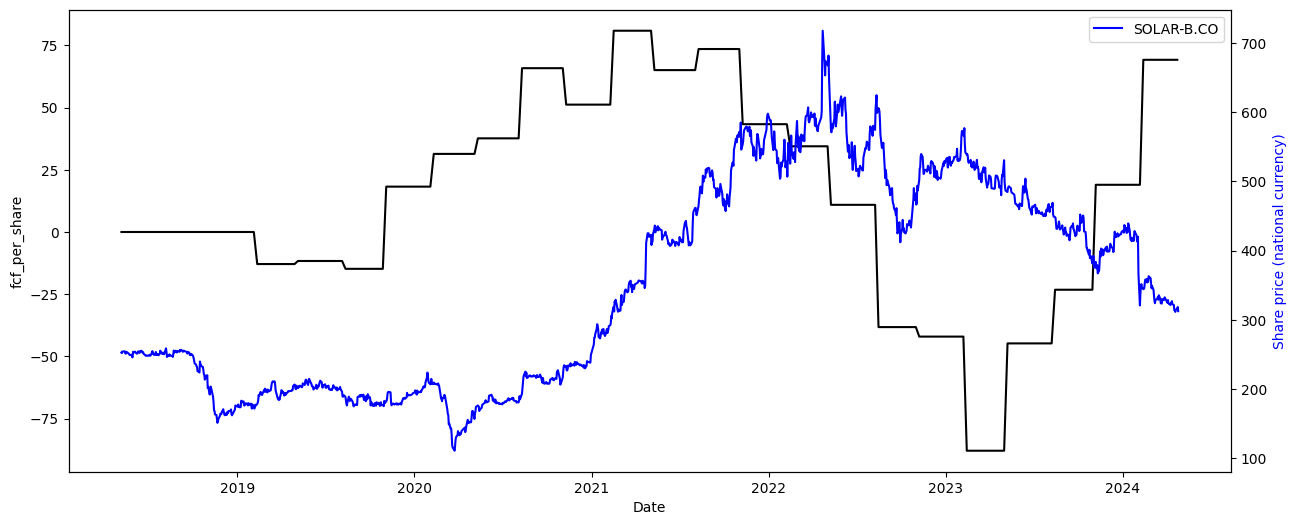

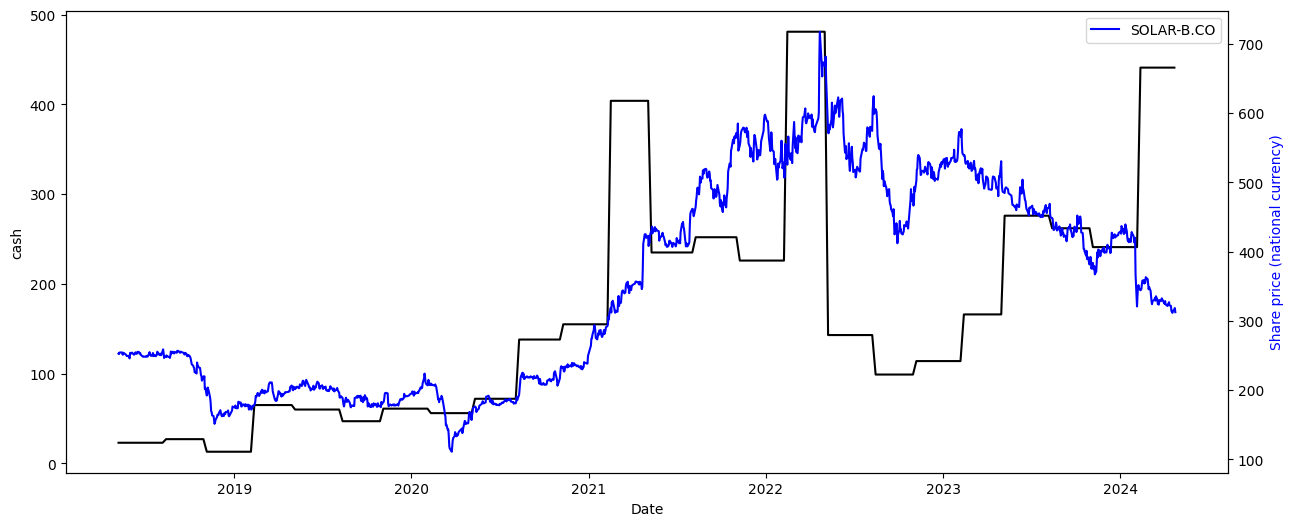

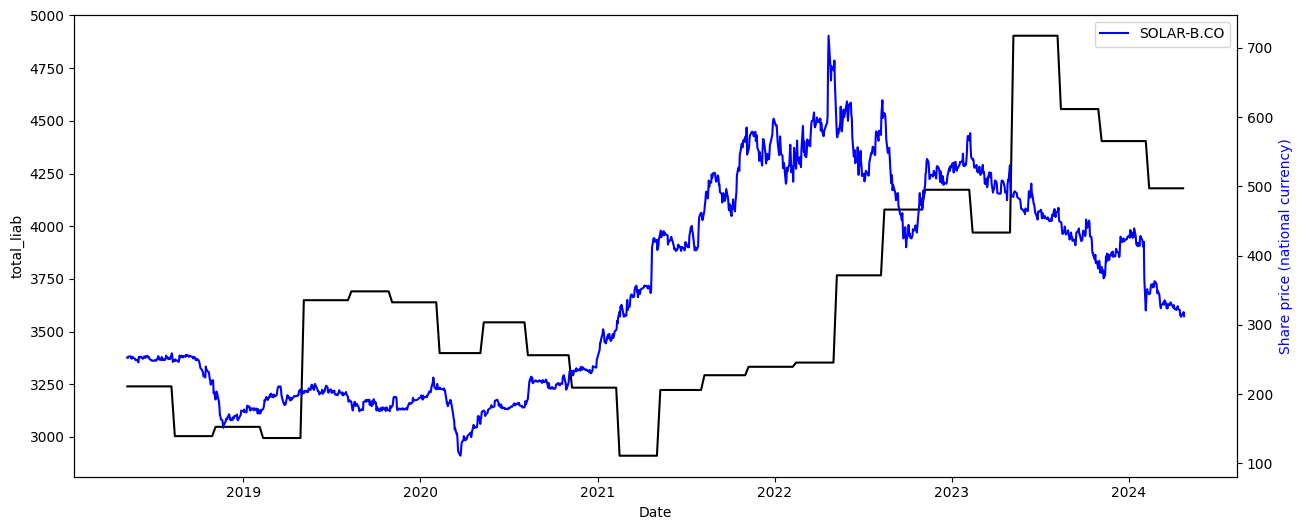

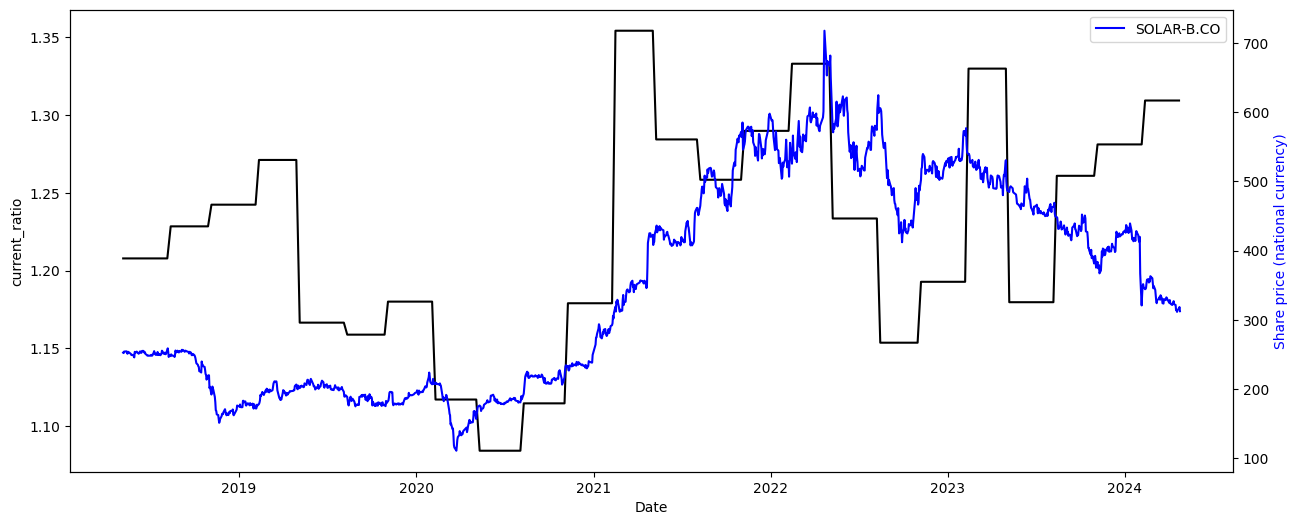

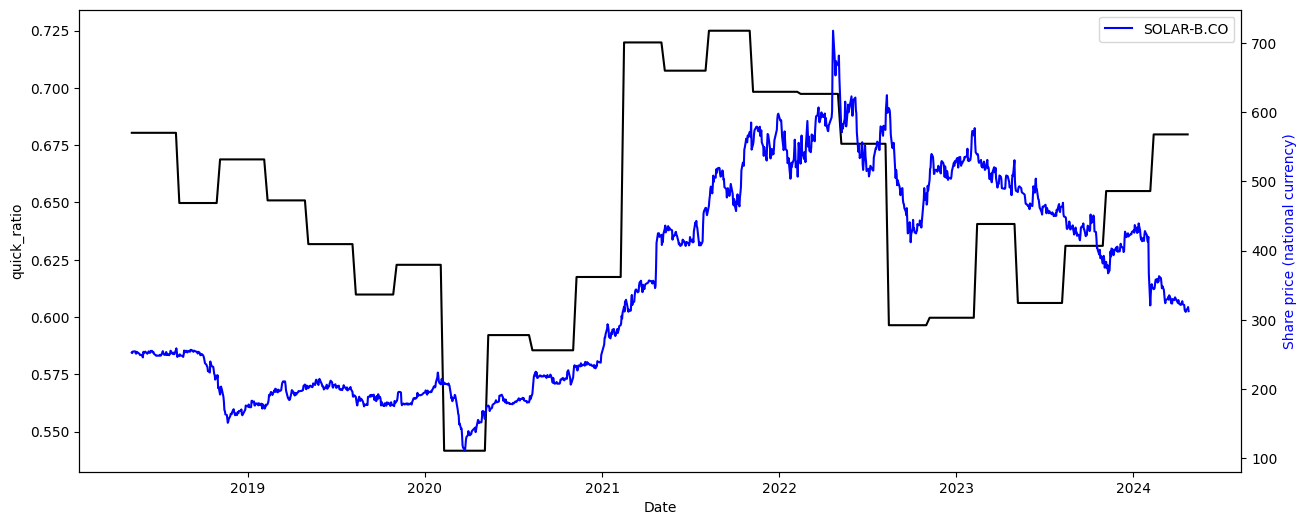

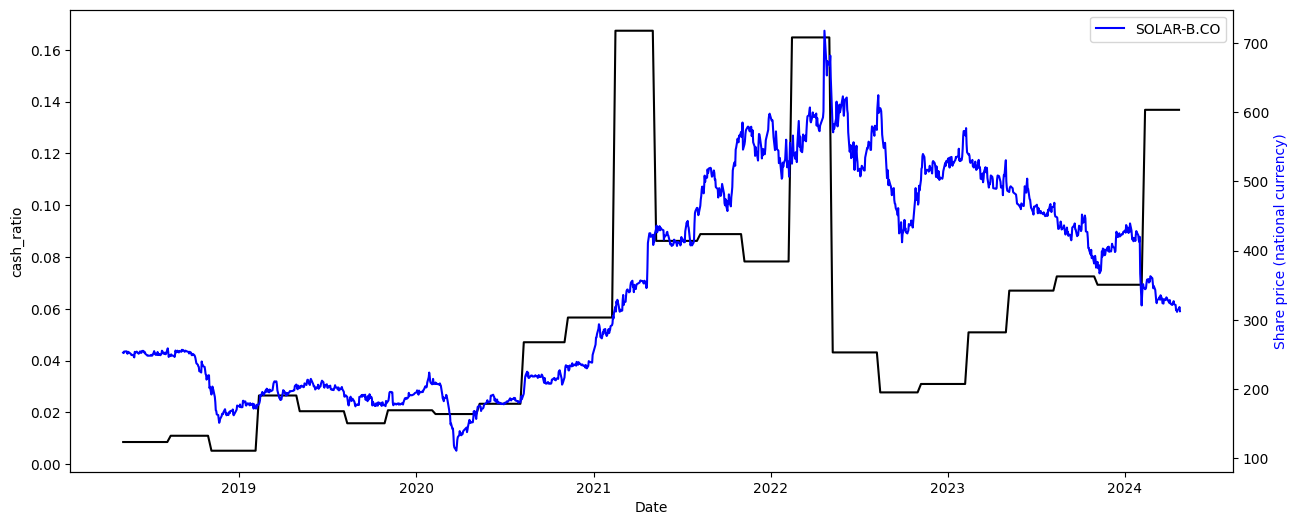

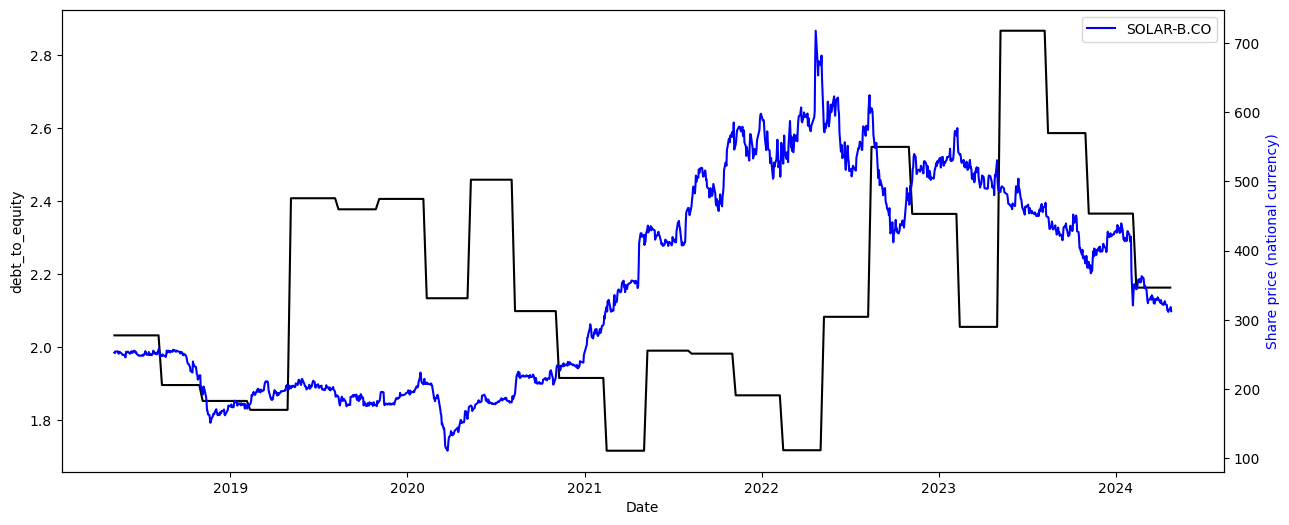

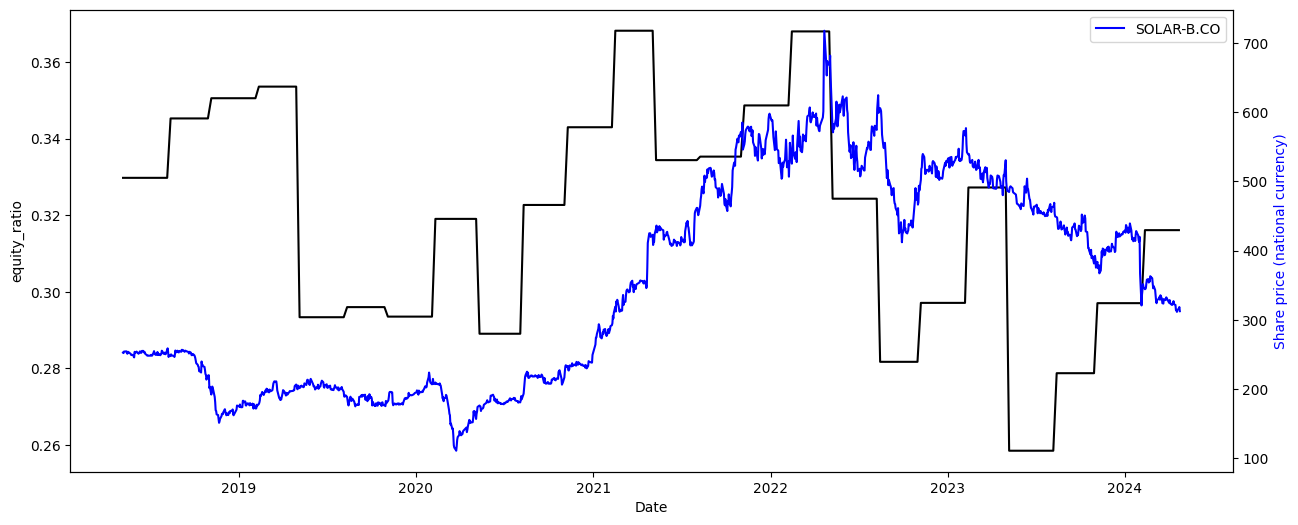

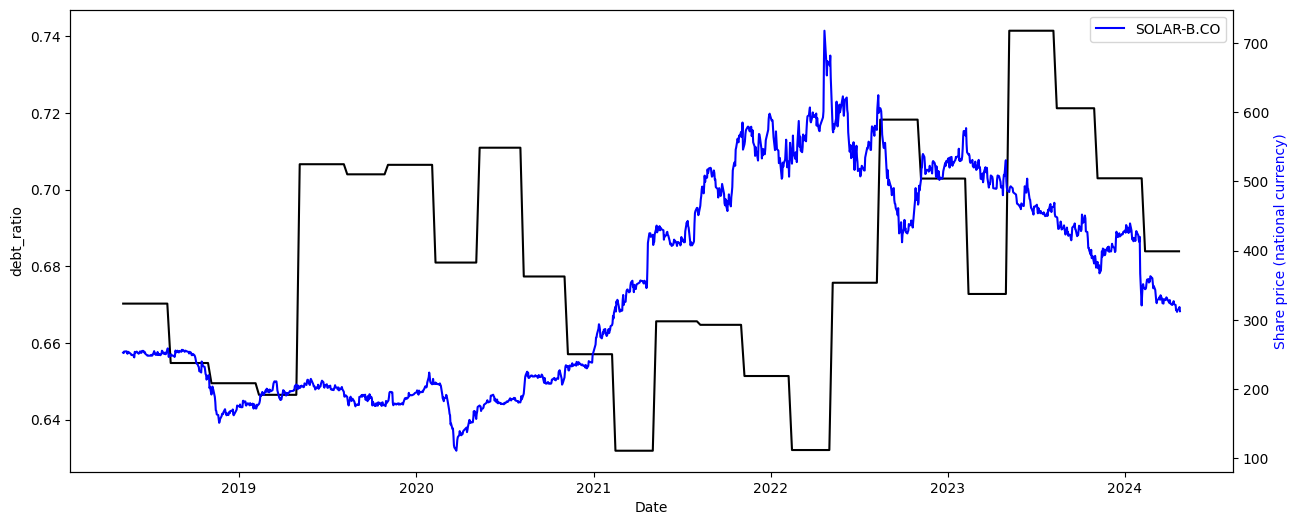

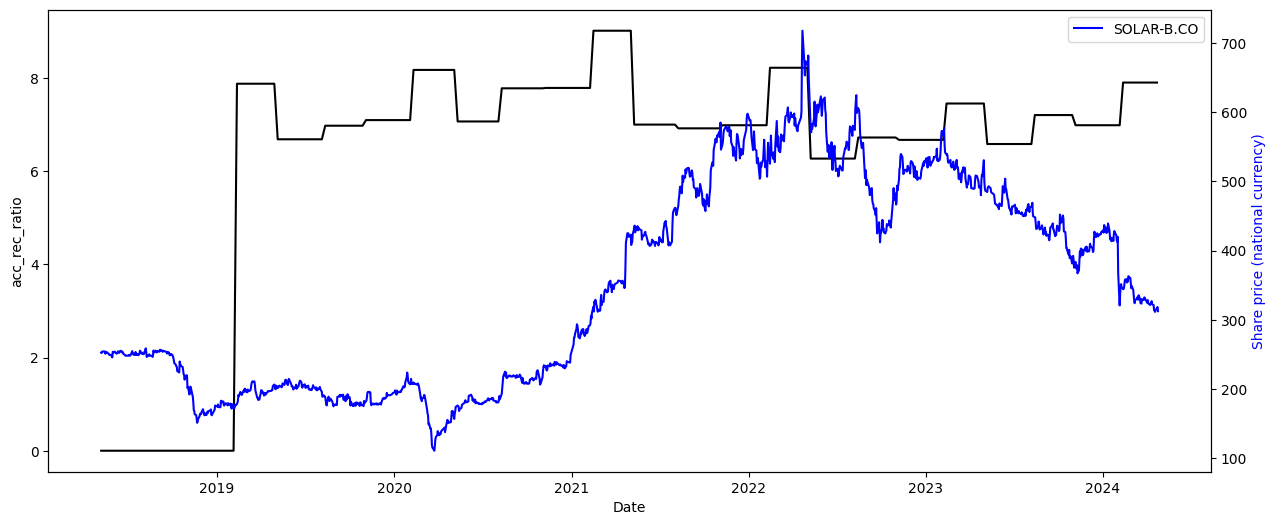

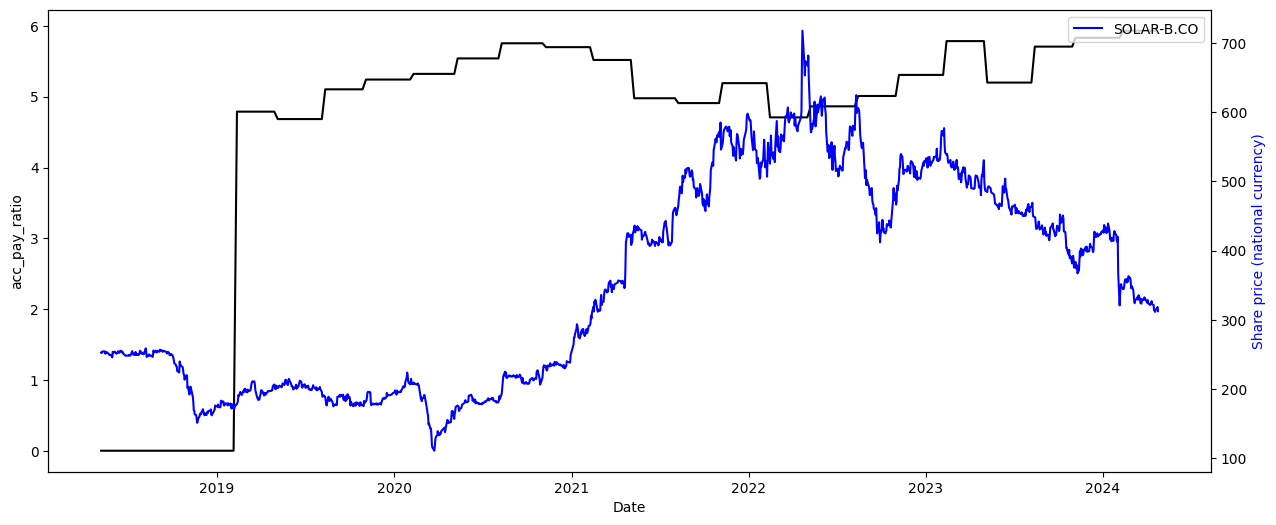

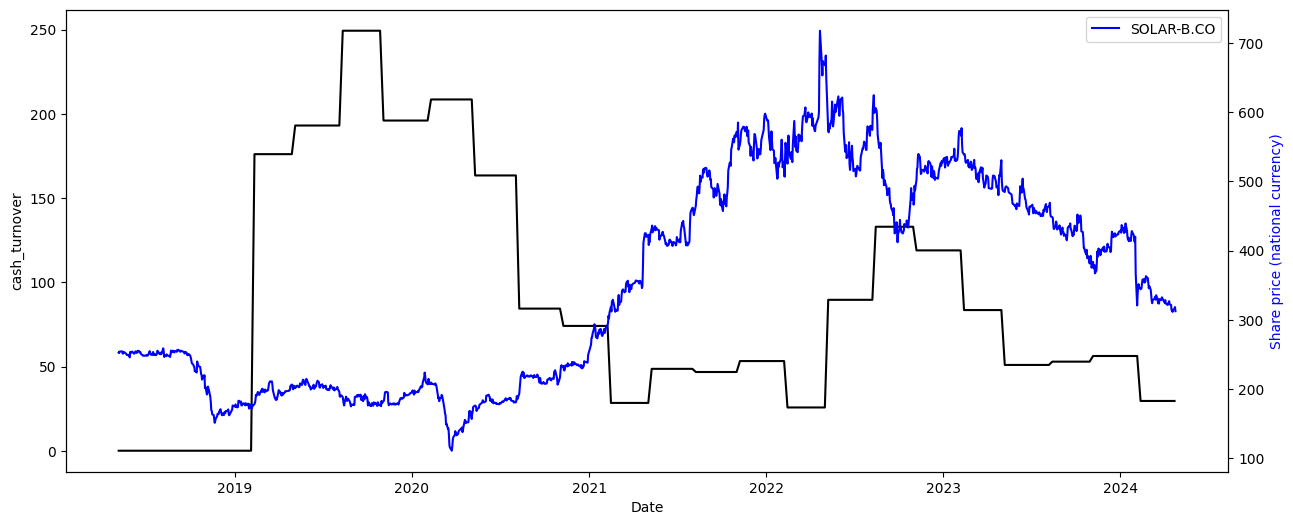

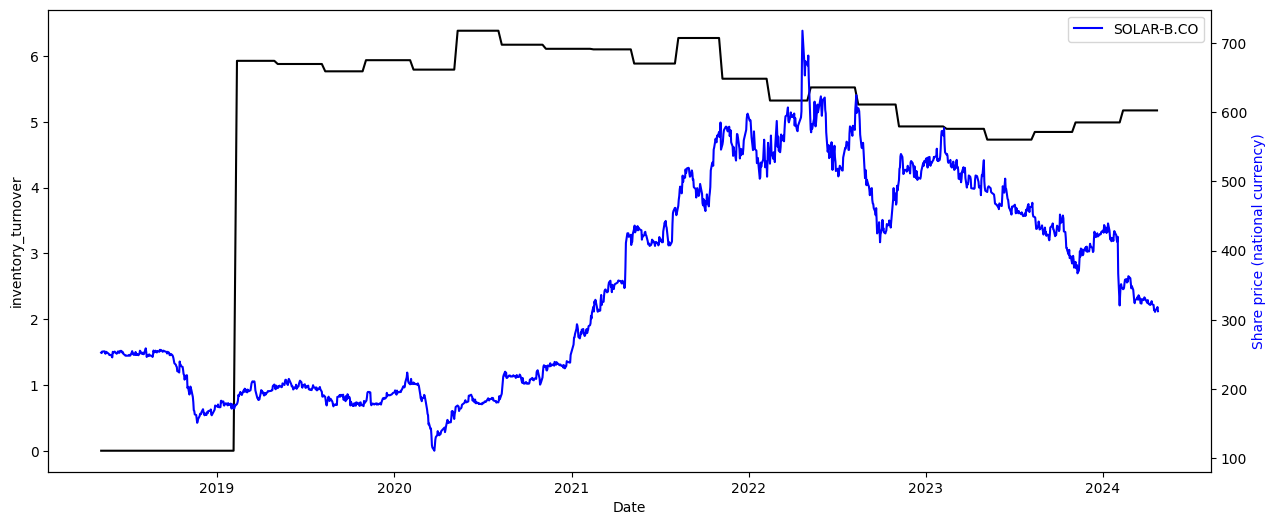

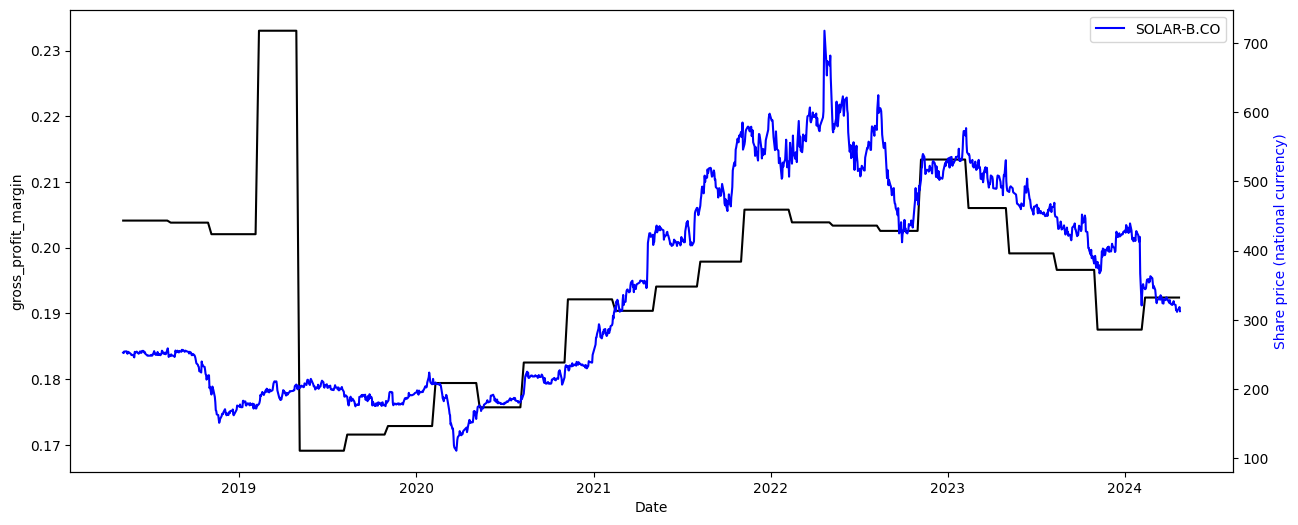

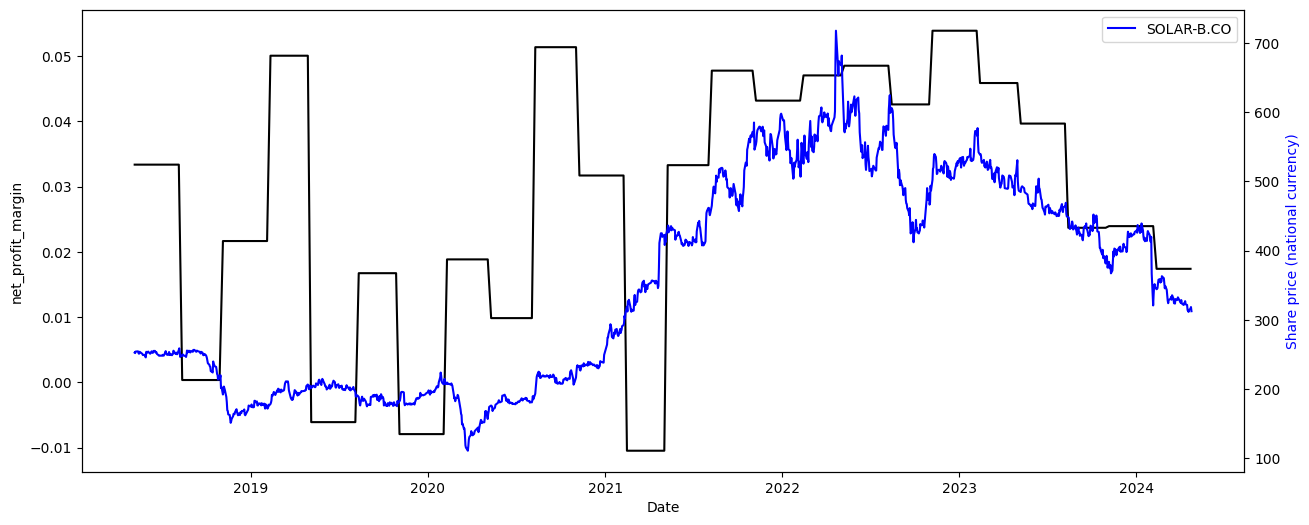

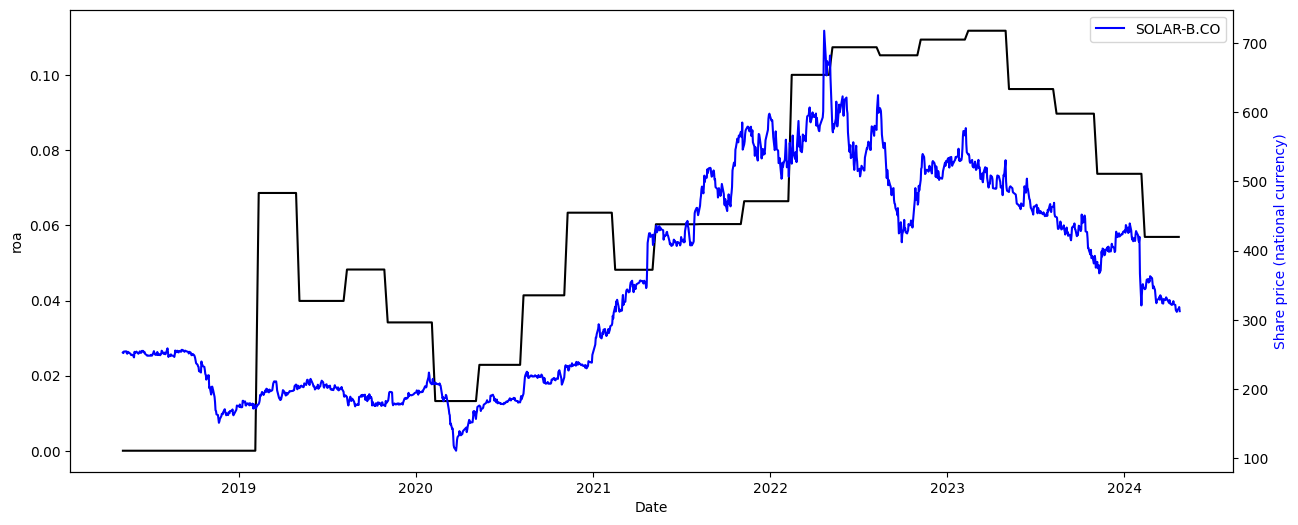

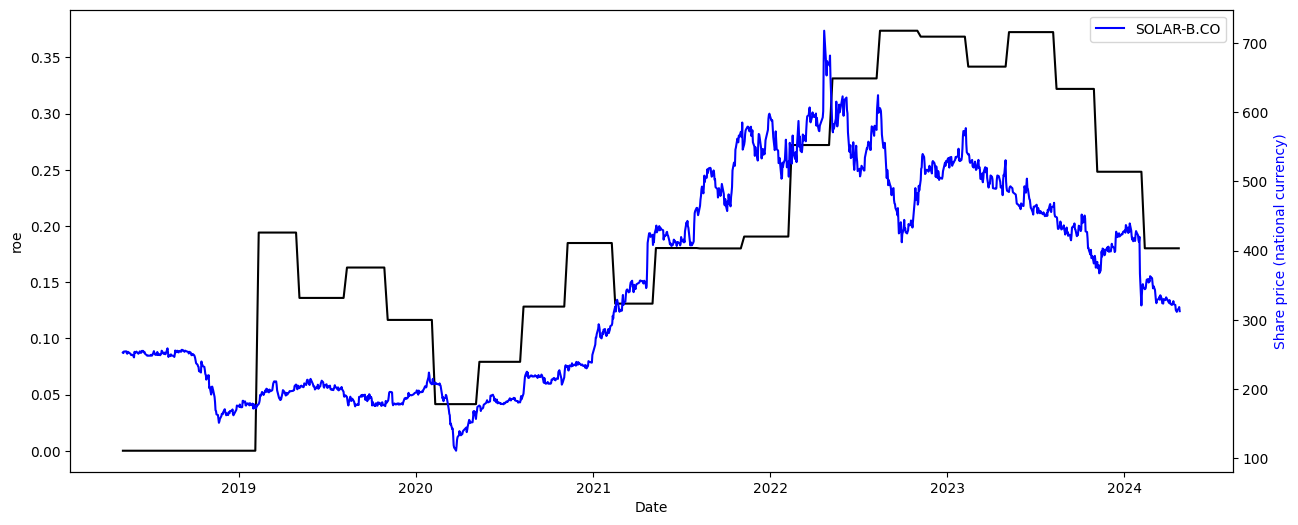

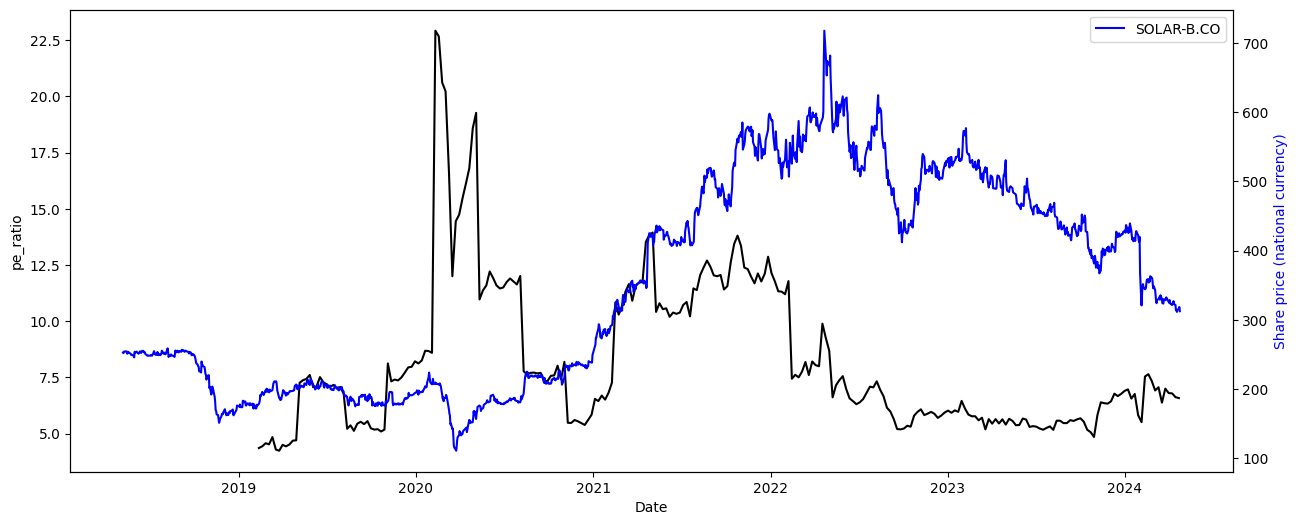

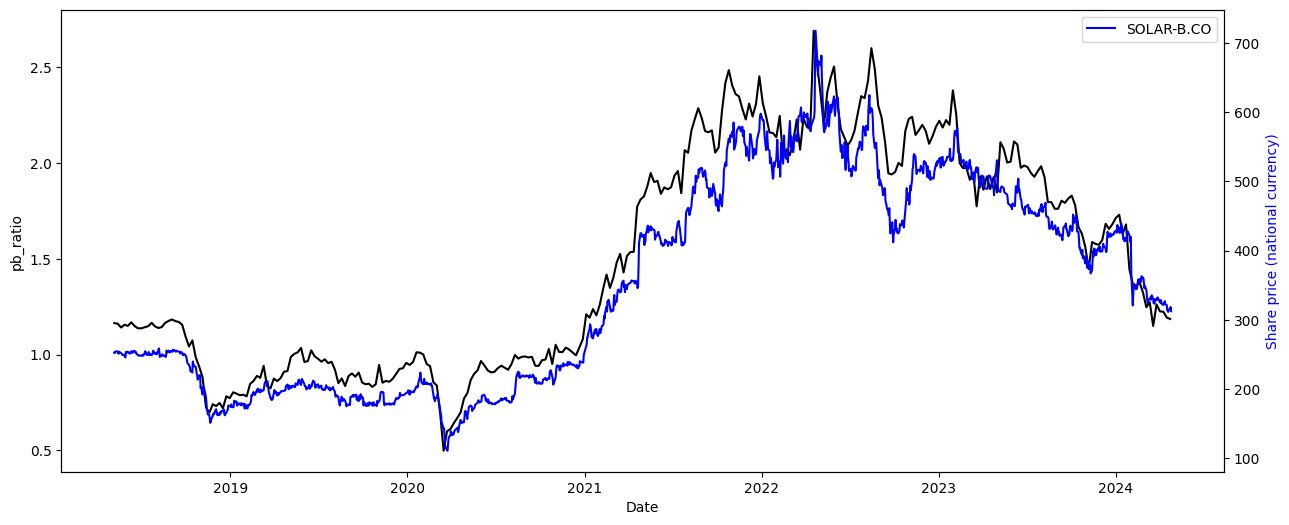

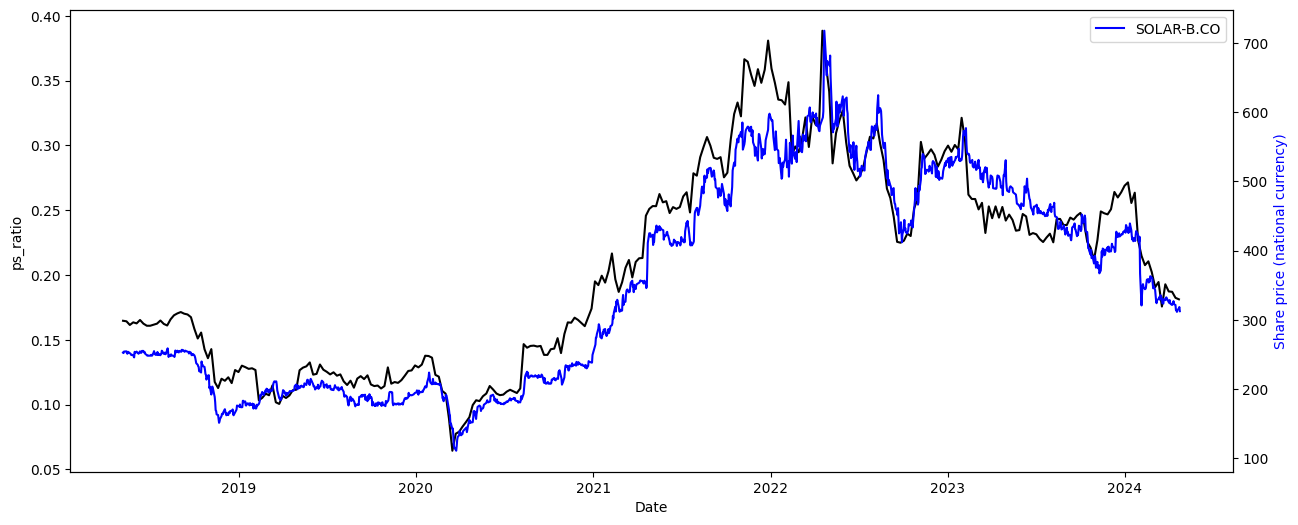

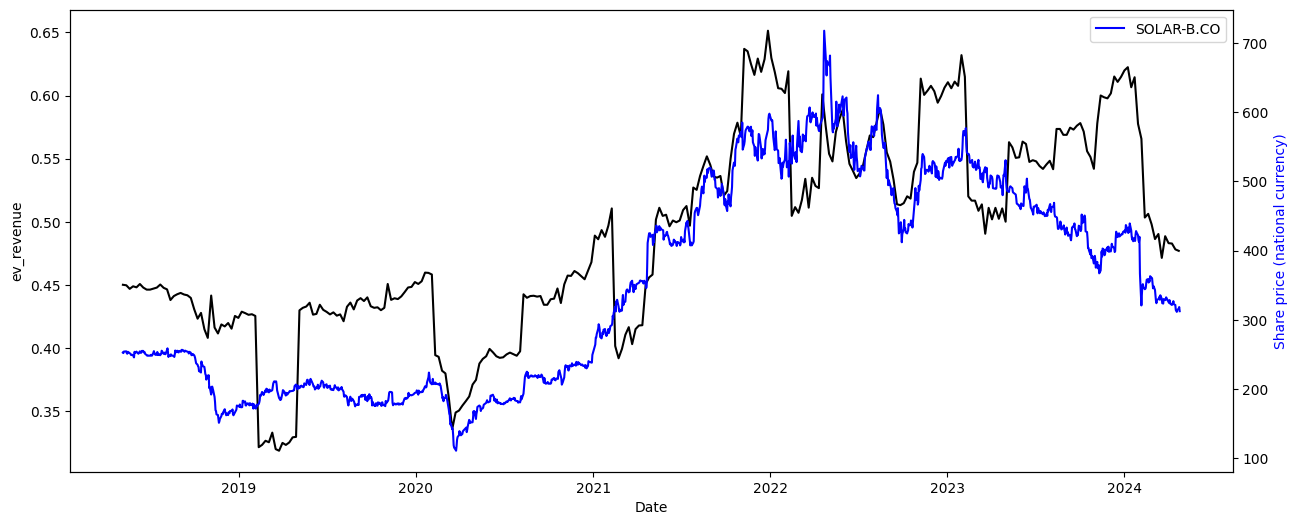

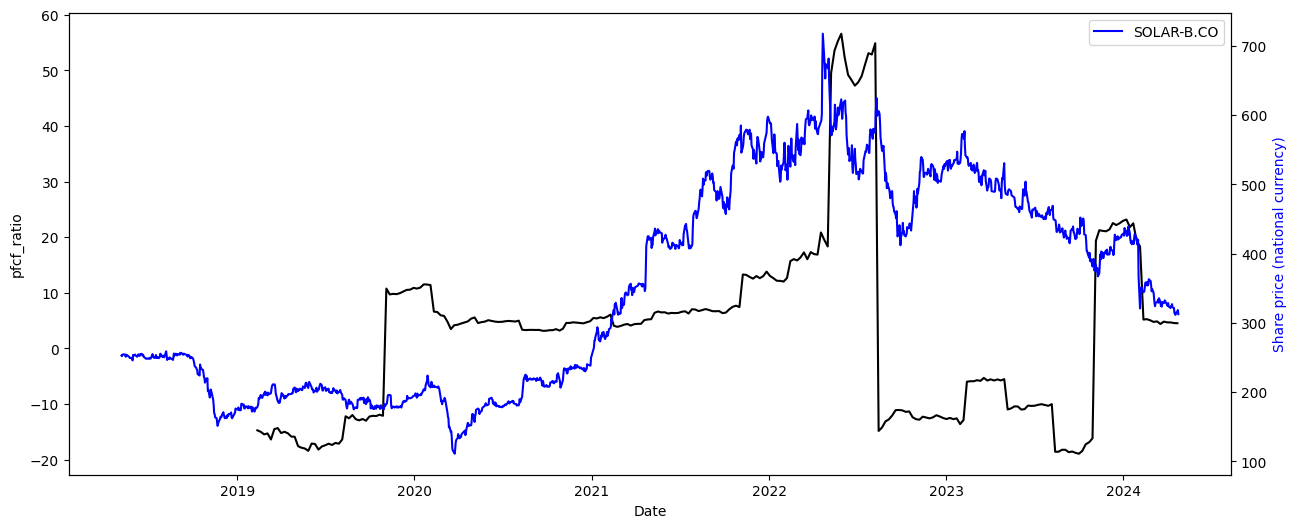

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

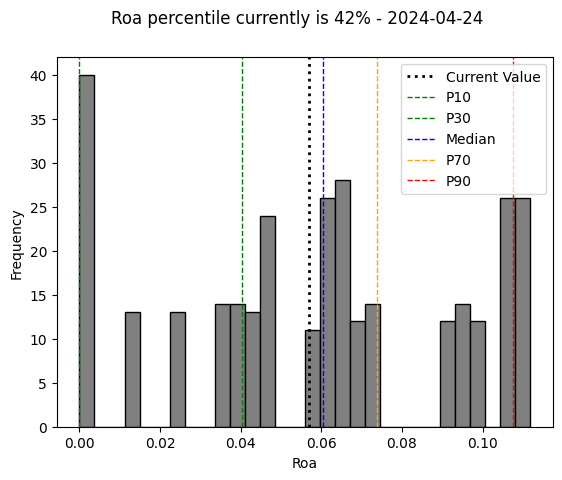

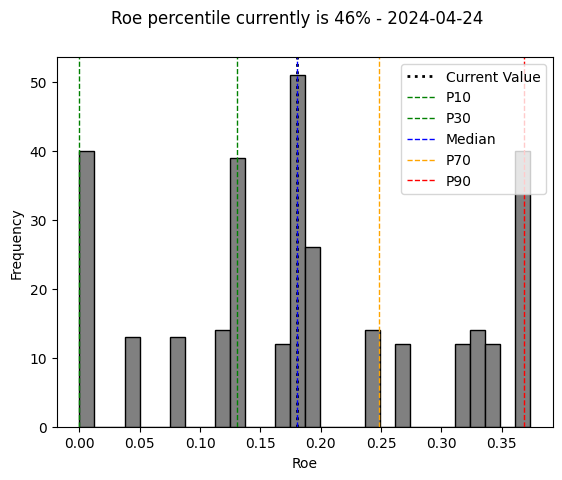

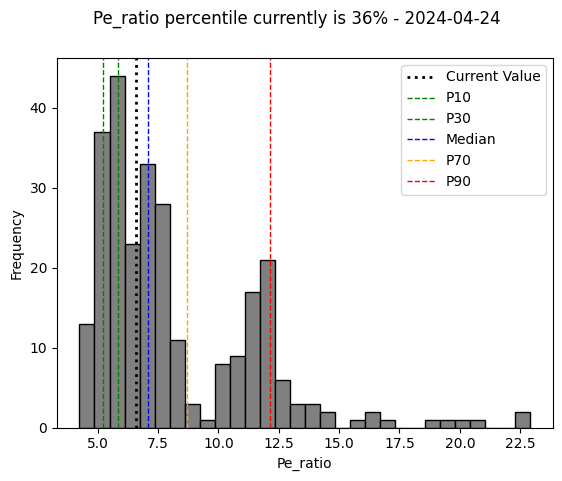

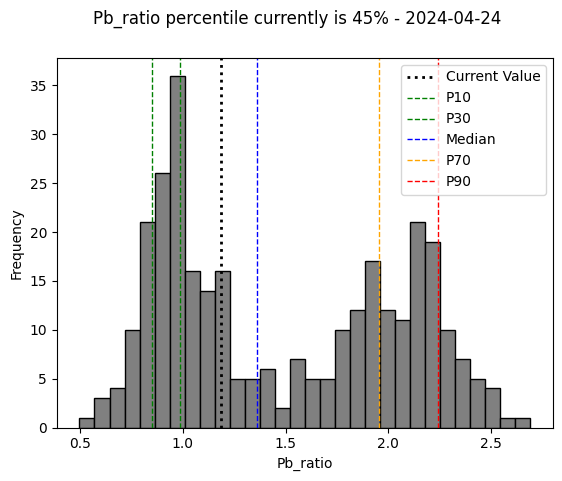

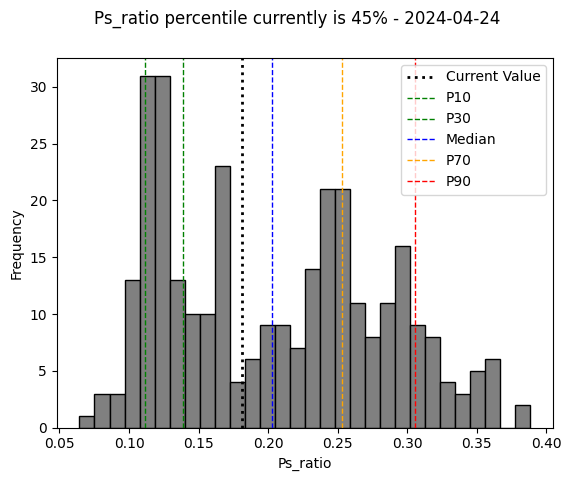

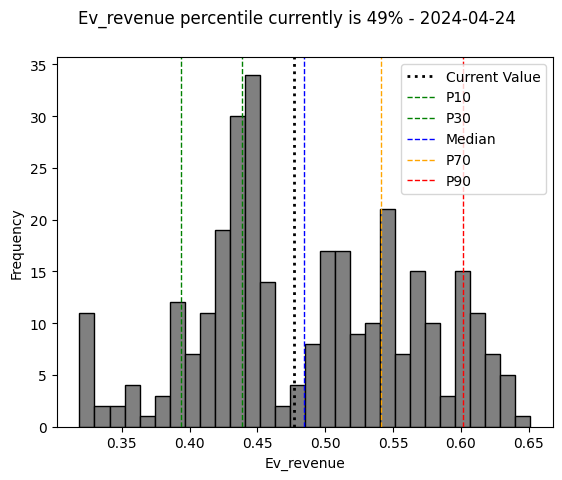

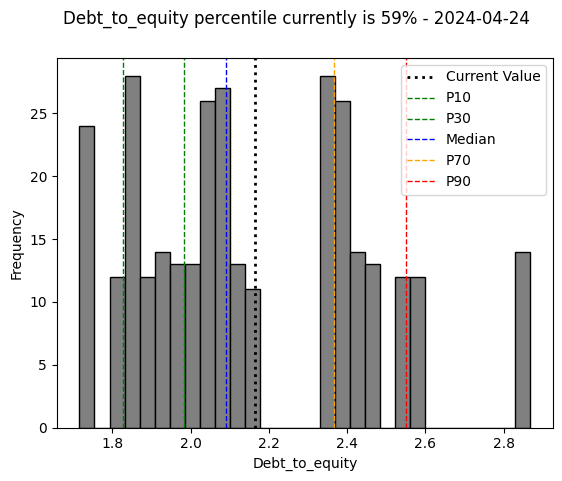

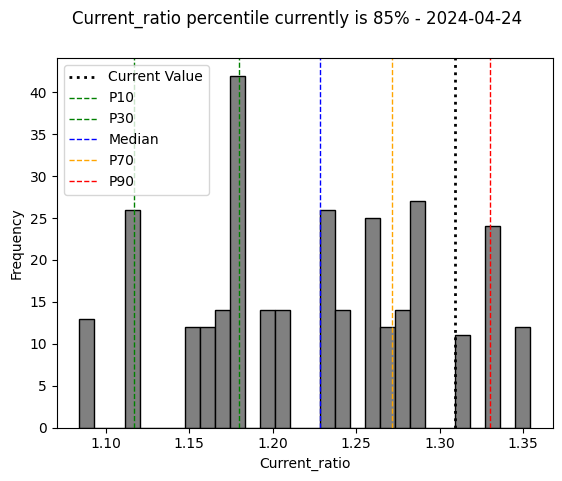

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.981344,-0.577662,0.770131,0.699588,0.664300,0.251647,0.316797
roe,0.981344,1.000000,-0.613707,0.741790,0.647499,0.677679,0.416975,0.213189
pe_ratio,-0.577662,-0.613707,1.000000,-0.056813,-0.016622,-0.181991,-0.325083,-0.085690
pb_ratio,0.770131,0.741790,-0.056813,1.000000,0.966837,0.854710,0.042222,0.446670
ps_ratio,0.699588,0.647499,-0.016622,0.966837,1.000000,0.893973,-0.101964,0.543296
ev_revenue,0.664300,0.677679,-0.181991,0.854710,0.893973,1.000000,0.232149,0.325355
debt_to_equity,0.251647,0.416975,-0.325083,0.042222,-0.101964,0.232149,1.000000,-0.522590
current_ratio,0.316797,0.213189,-0.085690,0.446670,0.543296,0.325355,-0.522590,1.000000


25 timestemos have been found!


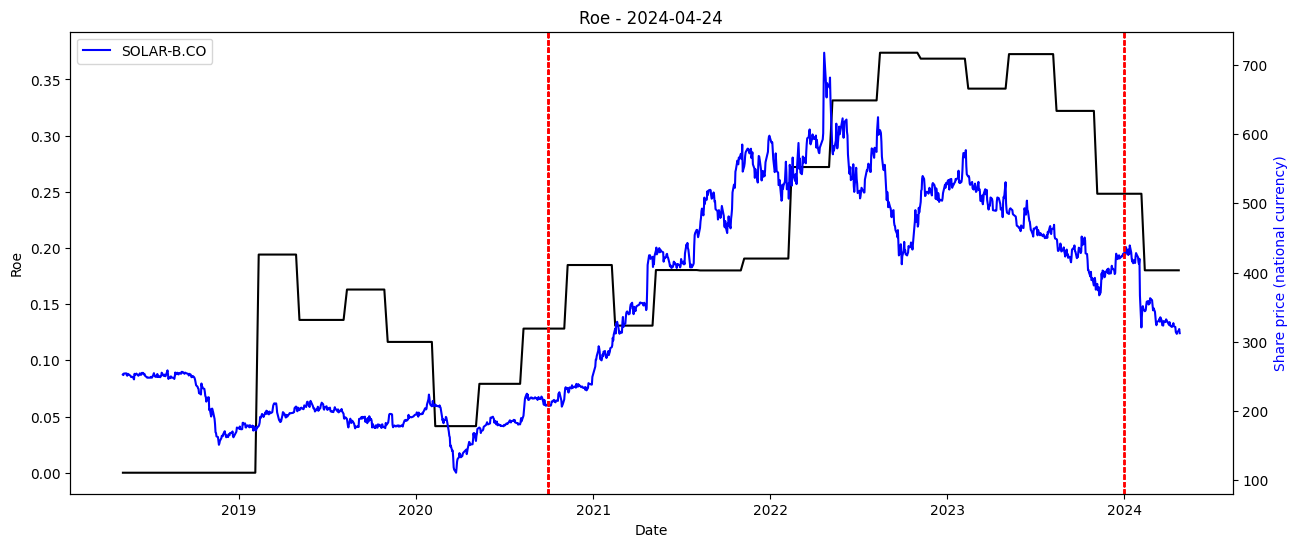

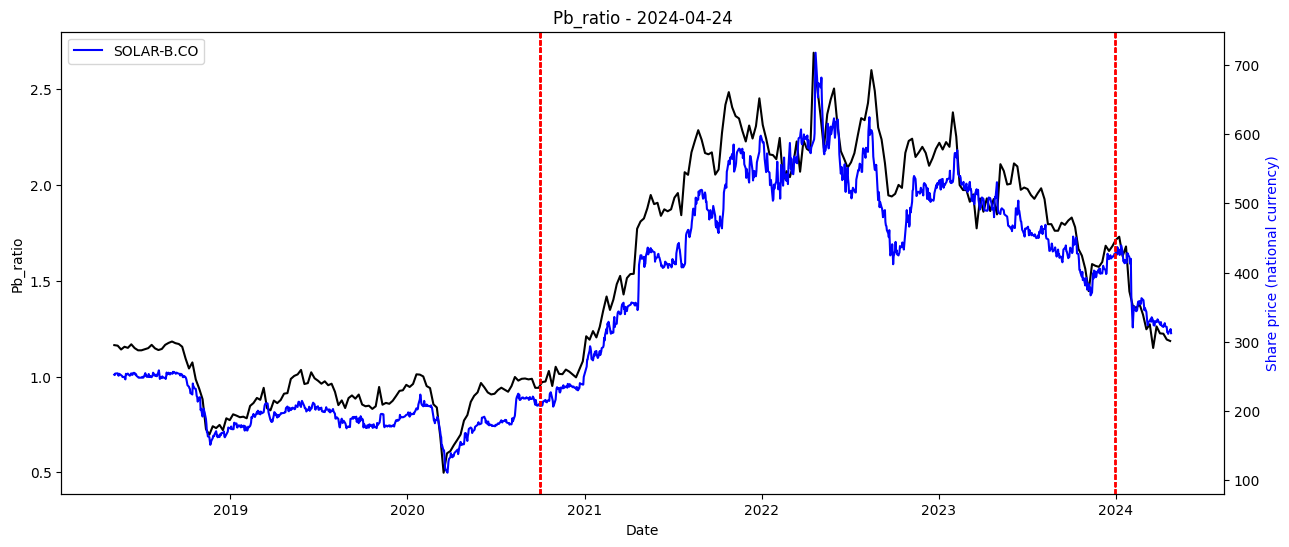

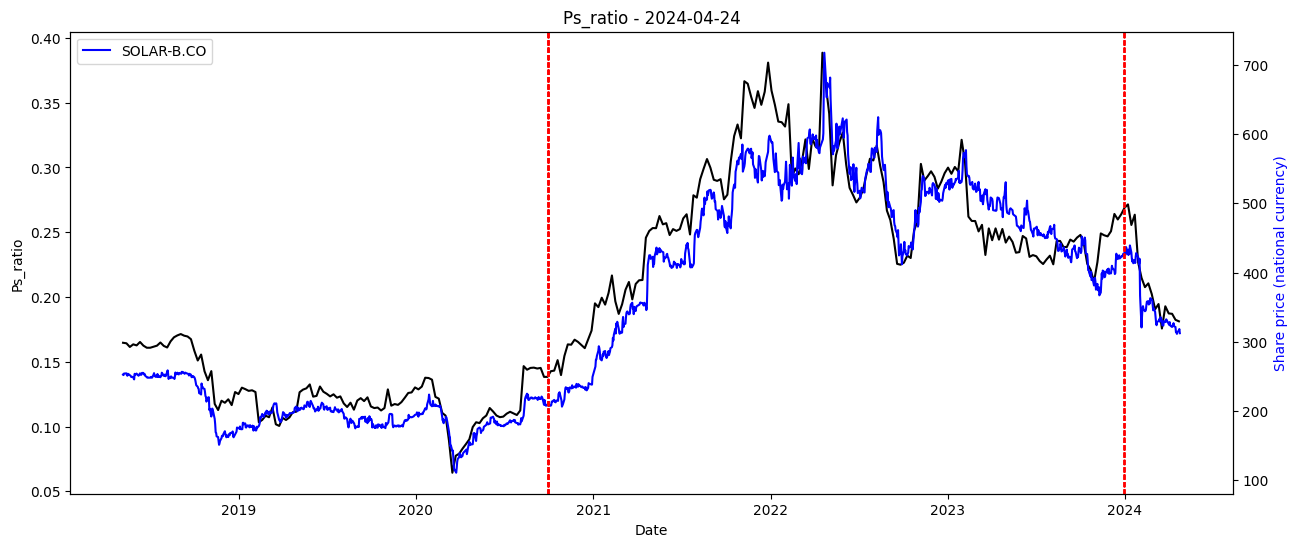

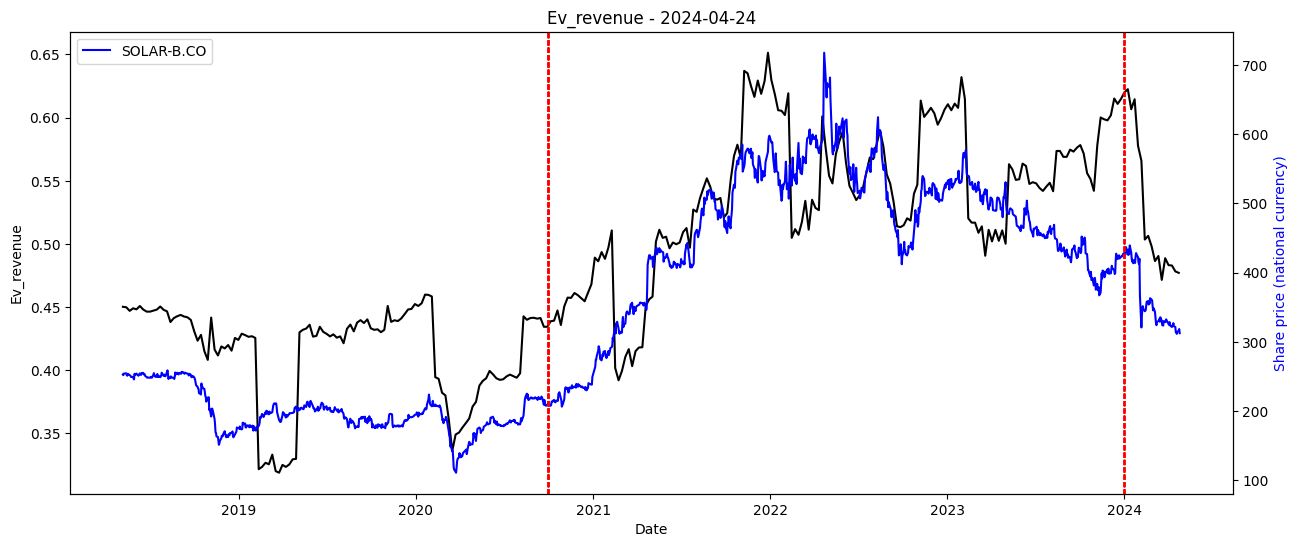

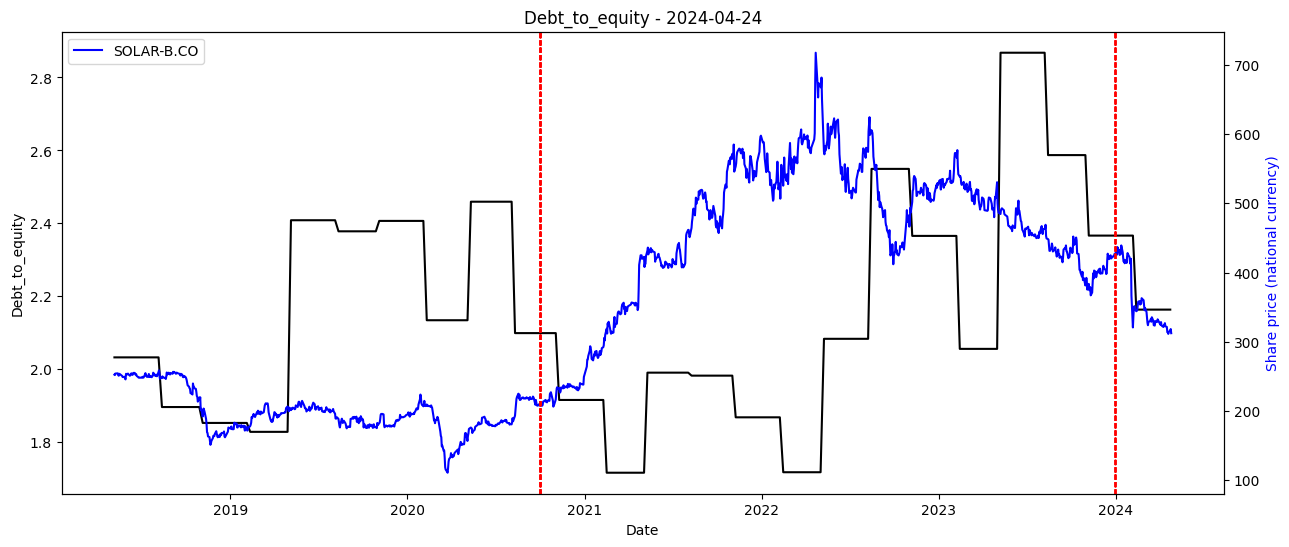

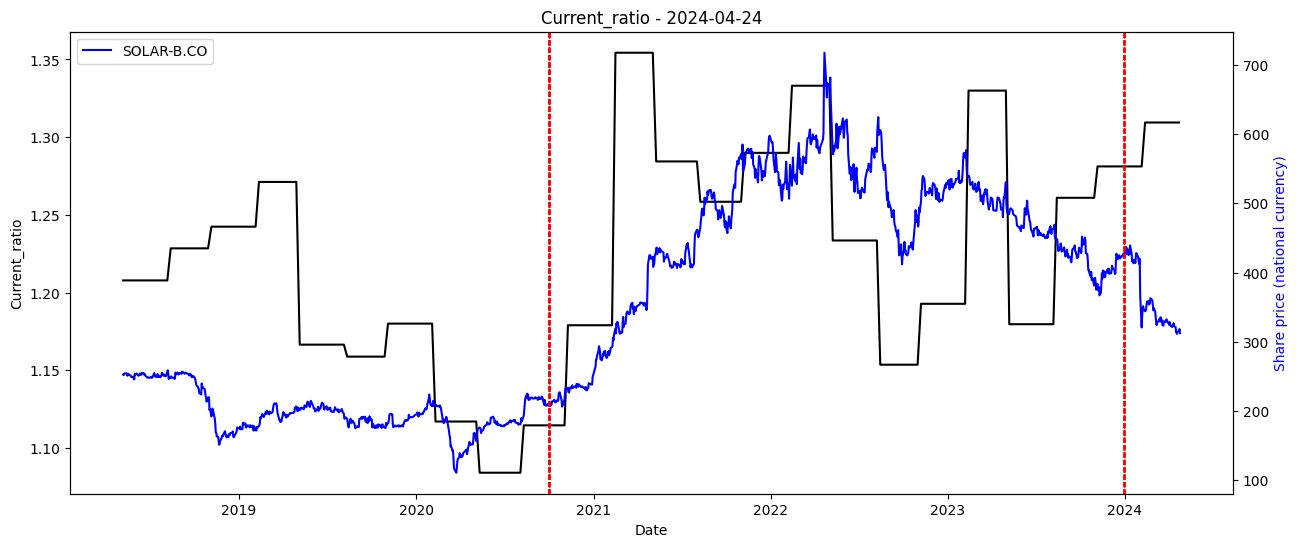

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )